In [2]:
import numpy as np

import theano 
import theano.tensor as T
from theano.tensor.signal import pool
from theano.tensor.nnet import conv2d


import IPython
import matplotlib.pyplot as plt
import timeit

%pylab inline
pylab.rcParams['figure.figsize'] = (6, 4)

%matplotlib inline
plt.rcParams['figure.figsize'] = (6.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Using gpu device 0: GeForce GTX 670MX (CNMeM is enabled with initial size: 10.0% of memory, cuDNN 5105)


Populating the interactive namespace from numpy and matplotlib


# State Farm Distracted Drivers

<img src="../resources/drivers_statefarm.png" width="900">


- c0: safe driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio
- c6: drinking
- c7: reaching behind
- c9: talking to passenger


## Les données 

79,726 photos à classer (ici on n'en charge que 200) 
22,424 photos d'entrainement (pour l'apprentissage et la validation)


In [14]:
X_test = np.load('../data/state-farm/X_test_40.npy')

# Pour récupérer les id des photos, pour faire une soumission sur Kaggle
X_test_id = np.load('../data/state-farm/X_test_id_40.npy')
print(X_test.shape,X_test_id.shape)

((200, 1600), (200,))


In [15]:
X_train = np.load('../data/state-farm/X_train_40.npy')
Y_train = np.load('../data/state-farm/y_train_40.npy')
print(X_train.shape, Y_train.shape)

((20424, 1600), (20424,))


In [16]:
X_valid= np.load('../data/state-farm/X_valid_40.npy')
Y_valid = np.load('../data/state-farm/y_valid_40.npy')
print(X_valid.shape, Y_valid.shape)

((2000, 1600), (2000,))


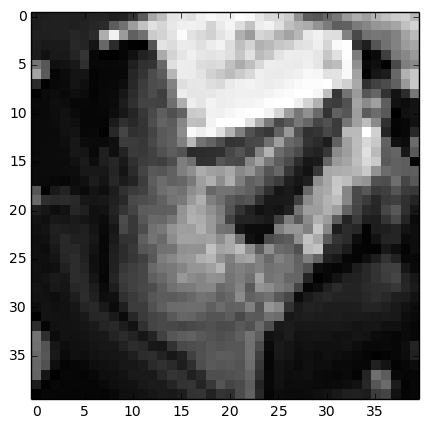

In [17]:
plt.imshow(X_valid[1234].reshape(40,40))


In [18]:
print(Y_valid[1234])

0


In [19]:
# On charge les données comme des variables partagées, pour le mini-batch SGD
X_train_shared =  T.cast(theano.shared(X_train),'float32')
y_train_shared = T.cast(theano.shared(Y_train),'int32')

X_valid_shared =  T.cast(theano.shared(X_valid),'float32')
y_valid_shared = T.cast(theano.shared(Y_valid),'int32')

X_test_shared =  T.cast(theano.shared(X_test),'float32')


## Construire le modèle 

In [20]:
learning_rate=0.01
n_epochs=50
batch_size=200
mu_1=0.00
mu_2=0.0001

n_kern1 = 5
n_kern2 = 5

n_features_map_1 = 6
n_features_map_2 = 12

n_out_fc1 = 100
n_out_fc2 = 100
n_out_softmax = 10

n_train_batches = X_train.shape[0] // batch_size
n_valid_batches = X_valid.shape[0] // batch_size

In [6]:
rng = np.random.RandomState(1234)

In [3]:
index = T.lscalar('index')

X = T.matrix('X')
Y = T.ivector('Y')

In [4]:
# On commence par une première couche qui va changer les dimensions de la 
layer0_input = X.reshape((batch_size, 1, 40, 40))

In [7]:
# Dimensions des données (#batch_size, 1 channel, 64x64)
image_shape_layer1=(batch_size, 1, 40, 40)

# dimension des paramètres: (#feature map en sortie, #feature map en entrée, #size_kernel, #size_kernel)
filter_shape_layer1=(n_features_map_1 ,1, n_kern1,n_kern1)

poolsize_layer1=(2, 2)



# Poids des filtres de la première couche de convolution
W_value = np.asarray( rng.uniform( size = filter_shape_layer1 ),
                        dtype=theano.config.floatX)

W_layer1 = theano.shared( value = W_value )



b_value = np.zeros( (filter_shape_layer1[0],), 
                   dtype=theano.config.floatX)

b_layer1 = theano.shared(value= b_value)



conv_out_layer1 = conv2d(
            input=layer0_input,
            filters=W_layer1,
            filter_shape=filter_shape_layer1,
            input_shape= image_shape_layer1
        )

pooled_out_layer1 = pool.pool_2d(
            input=conv_out_layer1,
            ds=poolsize_layer1,
            ignore_border=True
        )


#On passe la sortie + le biais dans la fonction d'activation 
output_layer1 = T.nnet.relu( pooled_out_layer1 + b_layer1.dimshuffle('x', 0, 'x', 'x'))

In [8]:
image_shape_layer2=(batch_size, n_features_map_1, 18, 18)
filter_shape_layer2=(n_features_map_2, n_features_map_1, n_kern2, n_kern2)
poolsize_layer2=(2, 2)


W_value = np.asarray( rng.uniform( size = filter_shape_layer2 ),
                        dtype=theano.config.floatX)

W_layer2 = theano.shared( value = W_value )

b_value = np.zeros( (filter_shape_layer2[0],), 
                   dtype=theano.config.floatX)

b_layer2 = theano.shared(value= b_value)



conv_out_layer2 = conv2d(
            input=output_layer1,
            filters=W_layer2,
            filter_shape=filter_shape_layer2,
            input_shape=image_shape_layer2
        )



pooled_out_layer2 = pool.pool_2d(
            input=conv_out_layer2,
            ds=poolsize_layer2,
            ignore_border=True
        )


output_layer2 = T.nnet.relu(pooled_out_layer2 + b_layer2.dimshuffle('x', 0, 'x', 'x'))

In [39]:
input_layer3 = output_layer2.flatten(2)

n_in_fc1 = n_features_map_2 * 7 * 7

W_layer3 = theano.shared(value=np.asarray(
                                    rng.uniform( low=-np.sqrt(6. / (n_in_fc1 + n_out_fc1)),
                                                 high=np.sqrt(6. / (n_in_fc1 + n_out_fc1)),
                                                size=(n_in_fc1, n_out_fc1)),
                                    dtype=theano.config.floatX),
                    name='W_layer3', borrow=True)

        
b_layer3 = theano.shared(value=np.zeros((n_out_fc1,), dtype=theano.config.floatX), name='b_layer3', borrow=True)

output_layer3 = T.nnet.relu(T.dot(input_layer3, W_layer3) + b_layer3)

In [40]:
n_in_fc2 = n_out_fc1

W_layer4 = theano.shared(value=np.asarray(
                                    rng.uniform( low=-np.sqrt(6. / (n_in_fc2 + n_out_fc2)),
                                                 high=np.sqrt(6. / (n_in_fc2 + n_out_fc2)),
                                                size=(n_in_fc2, n_out_fc2)),
                                    dtype=theano.config.floatX),
                    name='W_layer4', borrow=True)

        
b_layer4 = theano.shared(value=np.zeros((n_out_fc2,), dtype=theano.config.floatX), name='b_layer4', borrow=True)

output_layer4 = T.nnet.relu(T.dot(output_layer3, W_layer4) + b_layer4)

In [41]:
W_logReg = theano.shared(
            value=np.zeros(
                (n_out_fc2, n_out_softmax),
                dtype=theano.config.floatX
            ),
            name='W_logReg',
            borrow=True
        )
b_logReg = theano.shared(
            value=np.zeros(
                (n_out_softmax,),
                dtype=theano.config.floatX
            ),
            name='b_logReg',
            borrow=True
        )

In [42]:
params = [W_layer1, b_layer1, W_layer2, b_layer2, W_layer3, b_layer3, W_layer4, b_layer4,W_logReg, b_logReg]

L1 = sum([abs(param).sum() for param in params])
L2 = sum([(param**2).sum() for param in params])



In [43]:
p_y_given_x = T.nnet.softmax(T.dot(output_layer4, W_logReg) + b_logReg)

cost = -T.mean(T.log(p_y_given_x)[T.arange(Y.shape[0]), Y]) + mu_1*L1 + mu_2*L2

y_pred = T.argmax(p_y_given_x, axis=1)

errors = T.mean(T.neq(y_pred, Y))

In [44]:
validate_model = theano.function( 
        inputs=[index],
        outputs=[cost,errors],
        givens={
            X: X_valid_shared[index * batch_size: (index + 1) * batch_size],
            Y: y_valid_shared[index * batch_size: (index + 1) * batch_size]
        }
    )

In [45]:
gparams = [T.grad(cost, param) for param in params]

updates = [
        (param, param - learning_rate * gparam)
        for param, gparam in zip(params, gparams)
    ]

train_model = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            X: X_train_shared[index * batch_size: (index + 1) * batch_size],
            Y: y_train_shared[index * batch_size: (index + 1) * batch_size]
        }
    )

In [46]:
test_model = theano.function(
        inputs=[],
        outputs=p_y_given_x, 
        givens={
            X: X_test_shared[:]
        }
    )

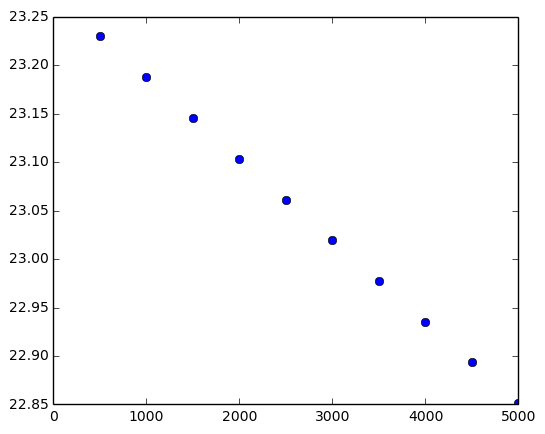

Entrainement fini : 2285.152054 %
en 74 secondes, avec 0.660956 epochs/sec


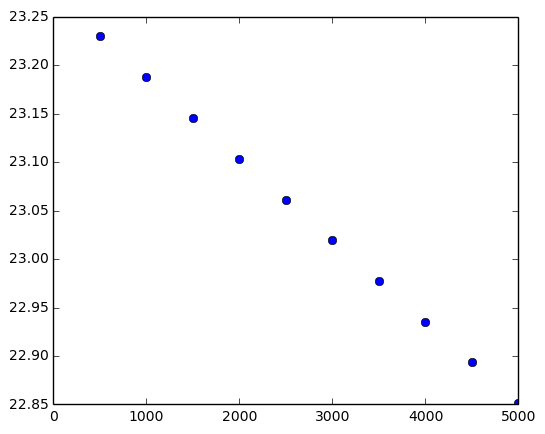

In [49]:
best_validation_loss = np.inf
validation_frequency = 500

start_time = timeit.default_timer()
for epoch in range(n_epochs):
    for minibatch_index in range(n_train_batches):
        
        minibatch_avg_cost = train_model(minibatch_index)
            
        # iteration number
        iter = (epoch) * n_train_batches + minibatch_index

        if (iter + 1) % validation_frequency == 0:
            this_validation_loss = np.mean([validate_model(i)[0]for i in range(n_valid_batches)])

            pylab.plot([iter], [this_validation_loss], 'bo', label='validation_loss')
            IPython.display.clear_output(wait=True)
            IPython.display.display(pylab.gcf())
        
            
            if this_validation_loss < best_validation_loss:
                best_validation_loss = this_validation_loss

end_time = timeit.default_timer()

print(( 'Entrainement fini : %f %%') % (best_validation_loss * 100.))
    
print('en %d secondes, avec %f epochs/sec' % ((end_time - start_time), 1. * epoch / (end_time - start_time)))

In [ ]:
predictions = test_model()